# Thử nghiệm: Một pipeline hiệu quả hơn VGG16?

# Preparation
Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
import shutil

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Data Path

Tải dữ liệu đã xử lý sẵn trên Google Drive

In [2]:
import os
project_dir = 'Project 1 - CV - Animal Image Classification/'
filter_path = project_dir + 'filtered-name/'
image_path = project_dir + 'animals/'
#os.makedirs(image_path, exist_ok=True)

In [3]:
folders = [f for f in os.listdir(filter_path) if os.path.isdir(os.path.join(filter_path, f))]
for folder in folders: print(folder, end = ' ')

seal armadillo otter opossum red_panda water_buffalo porcupine vampire_bat sugar_glider brown_bear mongoose dolphin weasel wildebeest sea_lion alpaca badger manatee koala mountain_goat vicuna warthog blue_whale tapir arctic_fox giraffe jackal orangutan groundhog baboon wombat yak african_elephant snow_leopard horse kangaroo squirrel polar_bear highland_cattle camel anteater american_bison rhinoceros walrus zebra 

In [4]:
for folder in folders:
  file_path = f'{filter_path}/{folder}/filtered-name.txt'

  with open(file_path, 'r') as file:
    for line in file:
      img = line.strip()
      path_img = f'{image_path}/{folder}/{img}'
      if os.path.exists(path_img):
        os.remove(path_img)
      else:
        print(f"{path_img} del-ed", end=" | ")

Project 1 - CV - Animal Image Classification/animals//seal/seal-0049.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0073.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0090.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0118.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0119.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0132.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0137.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0149.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0158.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0198.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0202.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0242.jpg del-ed | Project 1 - CV -

## Load data (with augmentation)

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Define the transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=image_path, transform=transform)

# Split dataset into training and validation sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create subsets for training and validation
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


# Khởi tạo mô hình

## Helpers

In [6]:
import datetime

from matplotlib import pyplot as plt
import json

def plot_learning_curve(history_dict, name=''):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history_dict['train_loss'], label='Train Loss')
  plt.plot(history_dict['test_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history_dict['train_accuracy'], label='Train Accuracy')
  plt.plot(history_dict['test_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout()
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plt.savefig(f'{name}')
  plt.show()

model_path = 'Project 1 - CV - Animal Image Classification/model and history'
def save_model(model, history_dict, name=''):
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plot_learning_curve(history_dict, name)
  torch.save(model.state_dict(), f'{model_path}/{name}.pth')
  with open(f'{model_path}/history_{name}.json', 'w') as f:
    json.dump(history_dict, f)

In [7]:

%pip install wandb -qqq
import wandb
wandb.login()
wandb.init(project="EffNet-Animals", entity="letangphuquy4-vietnam-korea-university-of-information-an")  # Replace "your_wandb_username" with your actual wandb username
wandb.config.update({"epochs": 30, "batch_size": 512,
                    "num_classes": 45, "img_size": 224})


Note: you may need to restart the kernel to use updated packages.


wandb: Currently logged in as: letangphuquy4 (letangphuquy4-vietnam-korea-university-of-information-an). Use `wandb login --relogin` to force relogin


wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.17.7


wandb: Run data is saved locally in /home/ltpq/ai4e/nlp/wandb/run-20240902_094906-j5sn19bu
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run desert-lake-5


wandb: ⭐️ View project at https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/EffNet-Animals


wandb: 🚀 View run at https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/EffNet-Animals/runs/j5sn19bu


## EfficientNetB3

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bars during training

def create_efficientnet_model(pretrained=True, lr=1e-3):
    base = models.efficientnet_b3(pretrained=pretrained)

    # Freeze the layers
    for param in base.parameters():
        param.requires_grad = False

    # Modify the classifier
    num_features = base.classifier[1].in_features
    base.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_features, 45)
    )

    # Define the optimizer
    optimizer = optim.SGD(base.classifier.parameters(), lr=lr, momentum=0.7)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    return base, optimizer, criterion

In [9]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

In [10]:
model, optimizer, criterion = create_efficientnet_model(pretrained=True, lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

history = {
    'train_loss': [],
    'test_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

# Training with frozen layers
num_epochs_frozen = 30
history = {
    'train_loss': [],
    'test_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

for epoch in range(num_epochs_frozen):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs_frozen} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs_frozen} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
                "test_loss": test_loss, "test_accuracy": test_accuracy})

/home/ltpq/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ltpq/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 - Train Loss: 3.8133, Train Accuracy: 0.0203
Epoch 1/30 - Test Loss: 3.7943, Test Accuracy: 0.0284


Epoch 2/30 - Train Loss: 3.7803, Train Accuracy: 0.0338
Epoch 2/30 - Test Loss: 3.7596, Test Accuracy: 0.0536


Epoch 3/30 - Train Loss: 3.7449, Train Accuracy: 0.0614
Epoch 3/30 - Test Loss: 3.7514, Test Accuracy: 0.0768


Epoch 4/30 - Train Loss: 3.7119, Train Accuracy: 0.0983
Epoch 4/30 - Test Loss: 3.6912, Test Accuracy: 0.1359


Epoch 5/30 - Train Loss: 3.6812, Train Accuracy: 0.1438
Epoch 5/30 - Test Loss: 3.6585, Test Accuracy: 0.1931


Epoch 6/30 - Train Loss: 3.6426, Train Accuracy: 0.2029
Epoch 6/30 - Test Loss: 3.6262, Test Accuracy: 0.2515


Epoch 7/30 - Train Loss: 3.6116, Train Accuracy: 0.2530
Epoch 7/30 - Test Loss: 3.5951, Test Accuracy: 0.2987


Epoch 8/30 - Train Loss: 3.5787, Train Accuracy: 0.3080
Epoch 8/30 - Test Loss: 3.5626, Test Accuracy: 0.3451


Epoch 9/30 - Train Loss: 3.5469, Train Accuracy: 0.3561
Epoch 9/30 - Test Loss: 3.5305, Test Accuracy: 0.3974


Epoch 10/30 - Train Loss: 3.5131, Train Accuracy: 0.3954
Epoch 10/30 - Test Loss: 3.4975, Test Accuracy: 0.4414


Epoch 11/30 - Train Loss: 3.4815, Train Accuracy: 0.4350
Epoch 11/30 - Test Loss: 3.4829, Test Accuracy: 0.4794


Epoch 12/30 - Train Loss: 3.4507, Train Accuracy: 0.4566
Epoch 12/30 - Test Loss: 3.4316, Test Accuracy: 0.5110


Epoch 13/30 - Train Loss: 3.4190, Train Accuracy: 0.4919
Epoch 13/30 - Test Loss: 3.4048, Test Accuracy: 0.5334


Epoch 14/30 - Train Loss: 3.3850, Train Accuracy: 0.5135
Epoch 14/30 - Test Loss: 3.3727, Test Accuracy: 0.5550


Epoch 15/30 - Train Loss: 3.3568, Train Accuracy: 0.5391
Epoch 15/30 - Test Loss: 3.3420, Test Accuracy: 0.5686


Epoch 16/30 - Train Loss: 3.3250, Train Accuracy: 0.5476
Epoch 16/30 - Test Loss: 3.3159, Test Accuracy: 0.5898


Epoch 17/30 - Train Loss: 3.2943, Train Accuracy: 0.5673
Epoch 17/30 - Test Loss: 3.2980, Test Accuracy: 0.5918


Epoch 18/30 - Train Loss: 3.2660, Train Accuracy: 0.5761
Epoch 18/30 - Test Loss: 3.2485, Test Accuracy: 0.6130


Epoch 19/30 - Train Loss: 3.2360, Train Accuracy: 0.5864
Epoch 19/30 - Test Loss: 3.2195, Test Accuracy: 0.6190


Epoch 20/30 - Train Loss: 3.2040, Train Accuracy: 0.6060
Epoch 20/30 - Test Loss: 3.2161, Test Accuracy: 0.6273


Epoch 21/30 - Train Loss: 3.1720, Train Accuracy: 0.6174
Epoch 21/30 - Test Loss: 3.1595, Test Accuracy: 0.6385


Epoch 22/30 - Train Loss: 3.1492, Train Accuracy: 0.6194
Epoch 22/30 - Test Loss: 3.1344, Test Accuracy: 0.6393


Epoch 23/30 - Train Loss: 3.1151, Train Accuracy: 0.6270
Epoch 23/30 - Test Loss: 3.1085, Test Accuracy: 0.6441


Epoch 24/30 - Train Loss: 3.0903, Train Accuracy: 0.6328
Epoch 24/30 - Test Loss: 3.0903, Test Accuracy: 0.6621


Epoch 25/30 - Train Loss: 3.0589, Train Accuracy: 0.6436
Epoch 25/30 - Test Loss: 3.0432, Test Accuracy: 0.6665


Epoch 26/30 - Train Loss: 3.0339, Train Accuracy: 0.6456
Epoch 26/30 - Test Loss: 3.0192, Test Accuracy: 0.6669


Epoch 27/30 - Train Loss: 3.0018, Train Accuracy: 0.6507
Epoch 27/30 - Test Loss: 2.9997, Test Accuracy: 0.6701


Epoch 28/30 - Train Loss: 2.9732, Train Accuracy: 0.6566
Epoch 28/30 - Test Loss: 3.1409, Test Accuracy: 0.6793


Epoch 29/30 - Train Loss: 2.9510, Train Accuracy: 0.6608
Epoch 29/30 - Test Loss: 2.9551, Test Accuracy: 0.6857


Epoch 30/30 - Train Loss: 2.9257, Train Accuracy: 0.6678
Epoch 30/30 - Test Loss: 2.9131, Test Accuracy: 0.6841


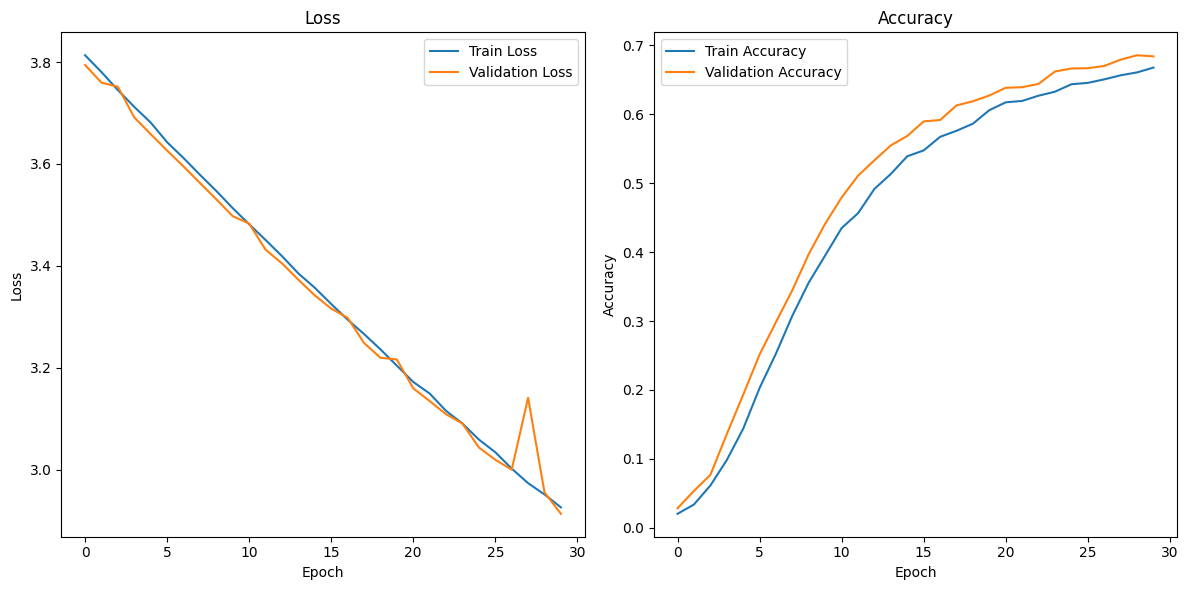

In [11]:
save_model(model, history, "eff_frozen")

In [12]:
# for param in model.parameters():
#     param.requires_grad = True
total_layers = len(list(model.features))  # assuming we unfreeze some of the layers in 'features'
unfreeze_layers = 4
for i, layer in enumerate(list(model.features)[-unfreeze_layers:]):
    for param in layer.parameters():
        param.requires_grad = True
# Redefine the optimizer for all parameters
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.7)

# Training with unfrozen layers
num_epochs_unfrozen = 20
for epoch in range(num_epochs_unfrozen):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    print(f"Epoch {epoch + 1 + num_epochs_frozen}/{num_epochs_unfrozen + num_epochs_frozen} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch + 1 + num_epochs_frozen}/{num_epochs_unfrozen + num_epochs_frozen} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
                "test_loss": test_loss, "test_accuracy": test_accuracy})

Epoch 31/50 - Train Loss: 2.9056, Train Accuracy: 0.6678
Epoch 31/50 - Test Loss: 2.8964, Test Accuracy: 0.6913


Epoch 32/50 - Train Loss: 2.8952, Train Accuracy: 0.6701
Epoch 32/50 - Test Loss: 2.8944, Test Accuracy: 0.6905


Epoch 33/50 - Train Loss: 2.8898, Train Accuracy: 0.6698
Epoch 33/50 - Test Loss: 2.8838, Test Accuracy: 0.6925


Epoch 34/50 - Train Loss: 2.8792, Train Accuracy: 0.6767
Epoch 34/50 - Test Loss: 2.8783, Test Accuracy: 0.6825


Epoch 35/50 - Train Loss: 2.8753, Train Accuracy: 0.6734
Epoch 35/50 - Test Loss: 2.8804, Test Accuracy: 0.6817


Epoch 36/50 - Train Loss: 2.8710, Train Accuracy: 0.6718
Epoch 36/50 - Test Loss: 2.8725, Test Accuracy: 0.6841


Epoch 37/50 - Train Loss: 2.8636, Train Accuracy: 0.6790
Epoch 37/50 - Test Loss: 2.8733, Test Accuracy: 0.6825


Epoch 38/50 - Train Loss: 2.8535, Train Accuracy: 0.6744
Epoch 38/50 - Test Loss: 2.8592, Test Accuracy: 0.6921


Epoch 39/50 - Train Loss: 2.8513, Train Accuracy: 0.6745
Epoch 39/50 - Test Loss: 2.8484, Test Accuracy: 0.7017


Epoch 40/50 - Train Loss: 2.8433, Train Accuracy: 0.6738
Epoch 40/50 - Test Loss: 2.8351, Test Accuracy: 0.7001


Epoch 41/50 - Train Loss: 2.8325, Train Accuracy: 0.6785
Epoch 41/50 - Test Loss: 2.8481, Test Accuracy: 0.6805


Epoch 42/50 - Train Loss: 2.8276, Train Accuracy: 0.6792
Epoch 42/50 - Test Loss: 2.8381, Test Accuracy: 0.6849


Epoch 43/50 - Train Loss: 2.8174, Train Accuracy: 0.6782
Epoch 43/50 - Test Loss: 2.8228, Test Accuracy: 0.6989


Epoch 44/50 - Train Loss: 2.8124, Train Accuracy: 0.6798
Epoch 44/50 - Test Loss: 2.8123, Test Accuracy: 0.6981


Epoch 45/50 - Train Loss: 2.8049, Train Accuracy: 0.6831
Epoch 45/50 - Test Loss: 2.8376, Test Accuracy: 0.6881


Epoch 46/50 - Train Loss: 2.8008, Train Accuracy: 0.6818
Epoch 46/50 - Test Loss: 2.7989, Test Accuracy: 0.6993


Epoch 47/50 - Train Loss: 2.7906, Train Accuracy: 0.6861
Epoch 47/50 - Test Loss: 2.7907, Test Accuracy: 0.7001


Epoch 48/50 - Train Loss: 2.7852, Train Accuracy: 0.6800
Epoch 48/50 - Test Loss: 2.7934, Test Accuracy: 0.7021


Epoch 49/50 - Train Loss: 2.7770, Train Accuracy: 0.6851
Epoch 49/50 - Test Loss: 2.7716, Test Accuracy: 0.7017


Epoch 50/50 - Train Loss: 2.7671, Train Accuracy: 0.6875
Epoch 50/50 - Test Loss: 2.7657, Test Accuracy: 0.7053


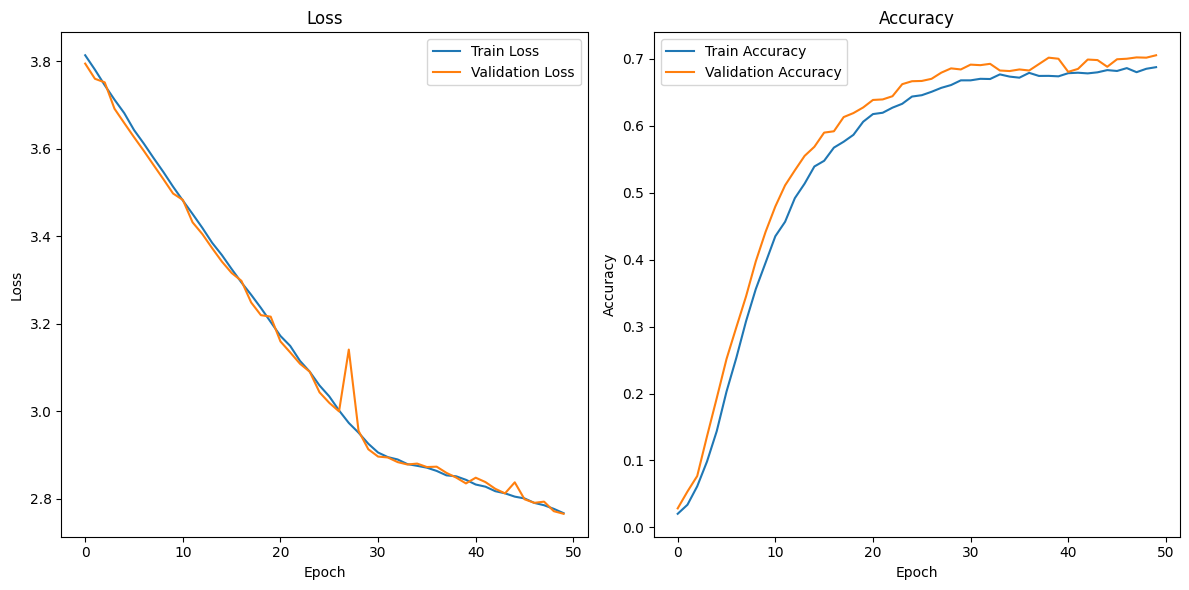

In [13]:
# Save the model and training history
save_model(model, history, "eff")

In [14]:
wandb.finish()

wandb:                                                                                


wandb: 
wandb: Run history:
wandb:  test_accuracy ▁▁▂▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇█████████████████████
wandb:      test_loss ███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb: train_accuracy ▁▁▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████████
wandb:     train_loss ███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:  test_accuracy 0.70532
wandb:      test_loss 2.76567
wandb: train_accuracy 0.68753
wandb:     train_loss 2.76706
wandb: 


wandb: 🚀 View run desert-lake-5 at: https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/EffNet-Animals/runs/j5sn19bu
wandb: ⭐️ View project at: https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/EffNet-Animals
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20240902_094906-j5sn19bu/logs


wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more information.


# New pipeline
Extractor:
- preset Filtering (kernels)
- CNN local extractor (EfficentNet)
- log-scaled Inception
- ViT global learner (concat to CNN local)

## Đề xuất
Trên cơ sở thí nghiệm với các model cho trước, nhóm em đề xuất pipeline như sau:
“InceptionV5” (nhiều bộ lọc global hơn)
Thêm đặc trưng filtering (Gabor, Sobel, Prewitt)


In [15]:
print("Hello World")

Hello World
